In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
import torch.nn as nn
import random
import itertools

In [3]:
def damped_harmonic_oscillator(t, m=1.0, mu=0.6, k=5.0, y0=-0.4, v0=3.0):
    # Check underdamped condition
    if mu**2 >= 4 * m * k:
        raise ValueError("The system is not underdamped. Ensure that μ^2 < 4 * m * k.")
    
    # Angular frequency
    omega = np.sqrt(k/m - (mu/(2*m)) ** 2)
    
    # Exact solution
    A = y0
    B = (v0 + (mu/(2*m)) * y0) / omega
    y_exact = np.exp(-mu * t / (2 * m)) * (A * np.cos(omega * t) + B * np.sin(omega * t))
    
    return y_exact

C:\Users\jolu2\AppData\Local\Temp\ipykernel_22352\3255437857.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


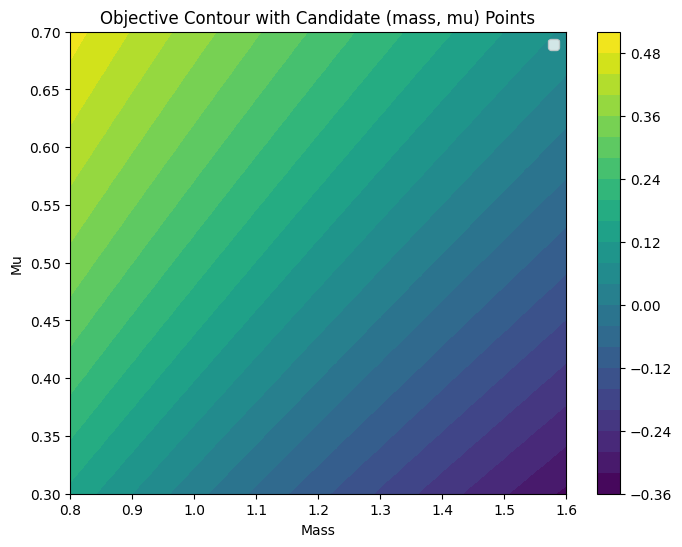

In [4]:
mass_mean = 1.0
mass_std = 0.1
mu_mean = 0.6
mu_std = 0.05
t_coll = torch.tensor(np.linspace(0, 3, 100), dtype=torch.float32)
k_fixed = 5.0
y0_fixed = -0.4
v0_fixed = 3.0

# --- Optional: Visualization of the Candidate Objective ---
mass_vals = np.linspace(mass_mean - 2 * mass_std, mass_mean + 6 * mass_std, 100)
mu_vals = np.linspace(mu_mean - 6 * mu_std, mu_mean + 2 * mu_std, 100)
Mass, Mu = np.meshgrid(mass_vals, mu_vals)
Obj = np.zeros_like(Mass)
for i in range(Mass.shape[0]):
    for j in range(Mass.shape[1]):
        y_exact = damped_harmonic_oscillator(t_coll.detach().numpy(), m=Mass[i, j], mu=Mu[i, j], k=k_fixed, y0=y0_fixed, v0=v0_fixed)
        Obj[i, j] = np.min(y_exact) + 1.0  # Compute the minimum value and add 1.0
        

plt.figure(figsize=(8, 6))
cp = plt.contourf(Mass, Mu, Obj, levels=20, cmap='viridis')
plt.colorbar(cp)
# plt.contour(Mass, Mu, Obj, levels=[0], colors='red', linestyles='--')  # Add a contour line at obj = 0
# plt.scatter([pt[0] for pt in sampled_points], [pt[1] for pt in sampled_points],
#             color='red', label='Candidate Points')
plt.xlabel('Mass')
plt.ylabel('Mu')
plt.title('Objective Contour with Candidate (mass, mu) Points')
plt.legend()
plt.show()

# Find failure probability 

In [5]:
# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define the PINN model
class PINN_m(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3, dropout_rate=0.05):
        super(PINN_m, self).__init__()
        input_dim = 6
        layers = [nn.Linear(input_dim, hidden_size), nn.Tanh()]
        
        for _ in range(hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
            layers.append(nn.Dropout(dropout_rate))
        
        layers.append(nn.Linear(hidden_size, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, t, m, mu, k, y0, v0):
        N = m.shape[0]
        mu_ = mu.expand(N, -1)
        k_  = k.expand(N, -1)
        y0_ = y0.expand(N, -1)
        v0_ = v0.expand(N, -1)
        x = torch.cat([t, m, mu_, k_, y0_, v0_], dim=1)
        return self.net(x)

class PINN_m_mu(PINN_m):
    def forward(self, t, m, mu, k, y0, v0):
        N = m.shape[0]
        k_  = k.expand(N, -1)
        y0_ = y0.expand(N, -1)
        v0_ = v0.expand(N, -1)
        x = torch.cat([t, m, mu, k_, y0_, v0_], dim=1)
        return self.net(x)

class PINN_all(PINN_m):
    def forward(self, t, m, mu, k, y0, v0):
        x = torch.cat([t, m, mu, k, y0, v0], dim=1)
        return self.net(x)

# Compute PDE loss
def pde_loss(model, t, m, mu, k, y0_val, v0_val):
    y = model(t, m, mu, k, y0_val, v0_val)
    y_t = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    y_tt = torch.autograd.grad(y_t, t, grad_outputs=torch.ones_like(y_t), create_graph=True)[0]
    residual = m * y_tt + mu * y_t + k * y
    return torch.mean(residual**2)

# Compute boundary loss
def boundary_loss(model, t0, m, mu, k, y0, v0):
    y_pred = model(t0, m, mu, k, y0, v0)
    y_t = torch.autograd.grad(y_pred, t0, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    return torch.mean((y_pred - y0)**2 + (y_t - v0)**2)

def plot_loss(epoch, losses_dict):
    plt.figure(figsize=(5, 3))
    for loss_name, loss_values in losses_dict.items():
        plt.plot(epoch, loss_values, label=loss_name)
    plt.yscale('log')
    plt.title('Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Initialize training parameters
def initialize_uniform_mass(N, m_mean=1.0, m_std=0.1):
    N = N
    t_coll = torch.rand(N, 1) * 5
    t_coll.requires_grad_(True)
    m_mean, m_std = m_mean, m_std
    m_coll = torch.FloatTensor(N, 1).uniform_(m_mean - 2 * m_std, m_mean + 8 * m_std)
    m_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    mu, k, y0, v0 = 0.6, 5.0, -0.4, 3.0
    # Define parameters as scalars (shape (1, 1))
    mu_val = torch.tensor([[mu]], requires_grad=True)
    k_val = torch.tensor([[k]], requires_grad=True)
    y0_val = torch.tensor([[y0]], requires_grad=True)
    v0_val = torch.tensor([[v0]], requires_grad=True)

    # Also define a single time for boundary condition
    t0 = torch.zeros_like(t_coll).clone().detach().requires_grad_(True)

    return t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0

def initialize_uniform_mass_mu(N, m_mean=1.0, m_std=0.1, mu_mean=0.6, mu_std=0.05):
    t_coll = torch.rand(N, 1) * 5
    t_coll.requires_grad_(True)
    m_mean, m_std = m_mean, m_std
    m_coll = torch.FloatTensor(N, 1).uniform_(m_mean -2 * m_std, m_mean + 8 * m_std)
    m_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    mu_mean, mu_std = mu_mean, mu_std
    mu_coll = torch.FloatTensor(N, 1).uniform_(mu_mean - 8 * mu_std, mu_mean + 2 * mu_std)
    mu_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    k, y0, v0 = 5.0, -0.4, 3.0
    # Define parameters as scalars (shape (1, 1))
    k_val = torch.tensor([[k]], requires_grad=True)
    y0_val = torch.tensor([[y0]], requires_grad=True)
    v0_val = torch.tensor([[v0]], requires_grad=True)

    # Also define a single time for boundary condition
    t0 = torch.zeros_like(t_coll).clone().detach().requires_grad_(True)

    return t_coll, m_coll, mu_coll, k_val, y0_val, v0_val, t0

def initialize_uniform_all():
    N = 500
    t_coll = torch.rand(N, 1) * 5
    t_coll.requires_grad_(True)
    m_mean, m_std = 1.0, 0.1
    mu_mean, mu_std = 0.6, 0.05
    k_mean, k_std = 5.0, 0.5
    y0_mean, y0_std = -0.4, 0.1
    v0_mean, v0_std = 3.0, 0.5
    m_coll = torch.FloatTensor(N, 1).uniform_(m_mean - 4 * m_std, m_mean + 4 * m_std)
    m_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    mu_coll = torch.FloatTensor(N, 1).uniform_(mu_mean - 4 * mu_std, mu_mean + 4 * mu_std)
    mu_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    k_coll = torch.FloatTensor(N, 1).uniform_(k_mean - 4* k_std, k_mean + 4 * k_std)
    k_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    y0_coll = torch.FloatTensor(N, 1).uniform_(y0_mean - 4 * y0_std, y0_mean + 4 * y0_std)
    y0_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    v0_coll = torch.FloatTensor(N, 1).uniform_(v0_mean - 4 * v0_std, v0_mean + 4 * v0_std)
    v0_coll.requires_grad_(True) # Set requires_grad to True for backpropagation

    # Also define a single time for boundary condition
    t0 = torch.zeros_like(t_coll).clone().detach().requires_grad_(True)

    return t_coll, m_coll, mu_coll, k_coll, y0_coll, v0_coll, t0

# Trainer class to manage training process
class Trainer:
    def __init__(self, model, optimizer, epochs=4001, lambda_bc=10.0):
        self.model = model
        self.optimizer = optimizer
        self.epochs = epochs
        self.losses = {"Residual Loss": [], "Boundary Loss": []}
        self.lambda_bc = lambda_bc
    
    def train(self, t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0):
        for epoch in range(self.epochs):
            self.optimizer.zero_grad()
            loss_pde = pde_loss(self.model, t_coll, m_val, mu_val, k_val, y0_val, v0_val)
            loss_bc = boundary_loss(self.model, t0, m_val, mu_val, k_val, y0_val, v0_val)
            loss = loss_pde + self.lambda_bc * loss_bc
            loss.backward()
            self.optimizer.step()
            
            self.losses["Residual Loss"].append(loss_pde.item())
            self.losses["Boundary Loss"].append(loss_bc.item())

            # if epoch % 1000 == 0:
                 
            #     m_val = update_mass()

            if epoch % 1000 == 0:
                print(f"Epoch {epoch}, PDE loss: {loss_pde.item()}, BC loss: {loss_bc.item()}")
                plot_loss(range(epoch + 1), self.losses)

## Finding MPP

### Uniformely distributed mass

Epoch 0, PDE loss: 0.8752022981643677, BC loss: 9.250069618225098


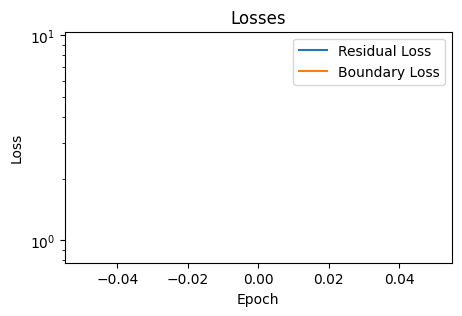

Epoch 1000, PDE loss: 0.34547358751296997, BC loss: 0.0009691172745078802


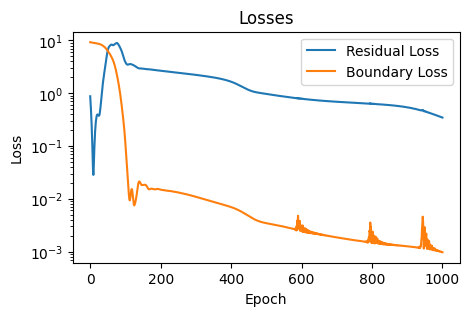

Epoch 2000, PDE loss: 0.0927608460187912, BC loss: 0.0002352774317841977


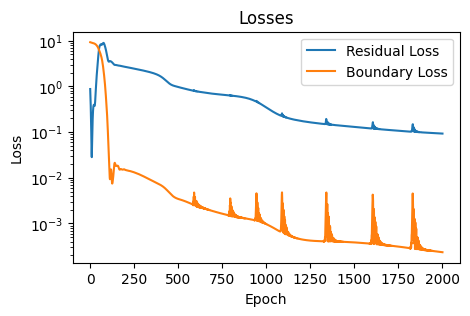

Epoch 3000, PDE loss: 0.06062218174338341, BC loss: 0.00013417238369584084


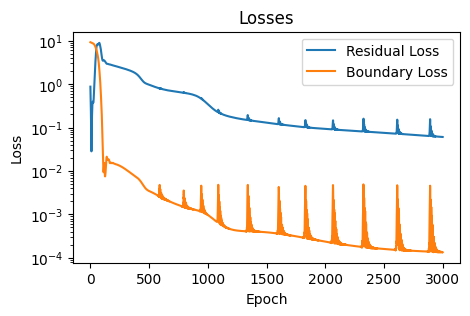

Epoch 4000, PDE loss: 0.03950357064604759, BC loss: 0.00010851055412786081


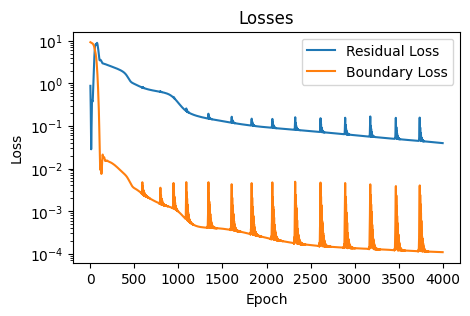

Epoch 5000, PDE loss: 0.024061013013124466, BC loss: 9.787780436454341e-05


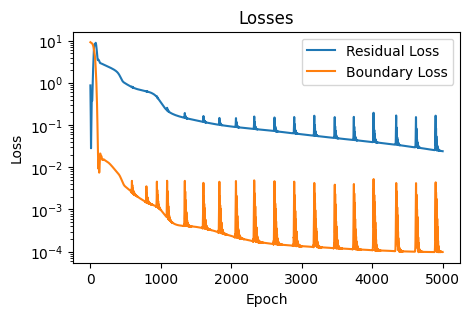

Epoch 6000, PDE loss: 0.014496667310595512, BC loss: 0.00010238874529022723


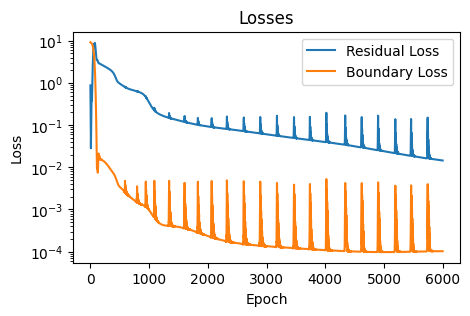

Epoch 7000, PDE loss: 0.010675902478396893, BC loss: 0.00011029191227862611


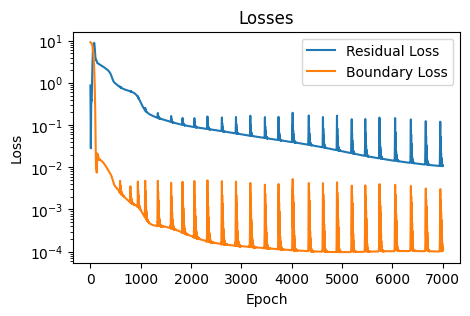

Epoch 8000, PDE loss: 0.00850241631269455, BC loss: 8.957170211942866e-05


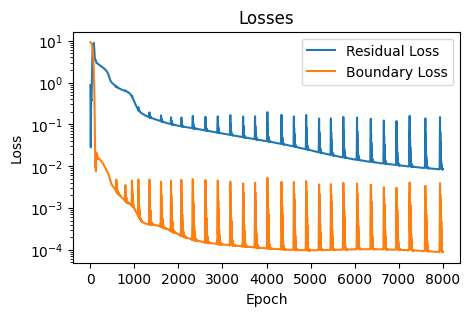

In [6]:
# Run training pipeline
set_seed()
t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0 = initialize_uniform_mass_mu(500)
mass_mu_model = PINN_m_mu(hidden_size=20, hidden_layers=3, dropout_rate=0.0)
optimizer = optim.Adam(mass_mu_model.parameters(), lr=0.001)
trainer = Trainer(mass_mu_model, optimizer,epochs=8001)
trainer.train(t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0)

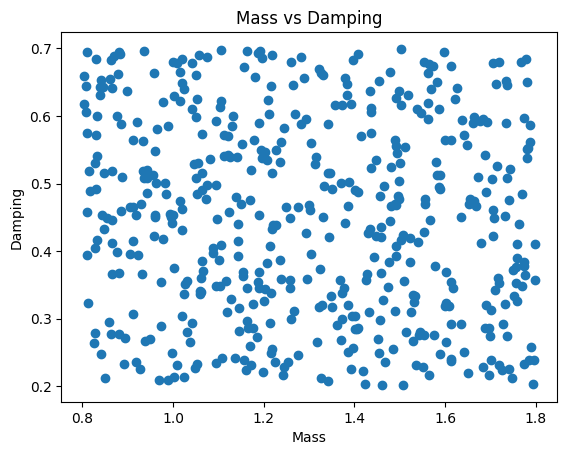

In [7]:
plt.plot(m_val.detach().numpy(), mu_val.detach().numpy(), 'o')
plt.xlabel('Mass')
plt.ylabel('Damping')
plt.title('Mass vs Damping')
plt.show()


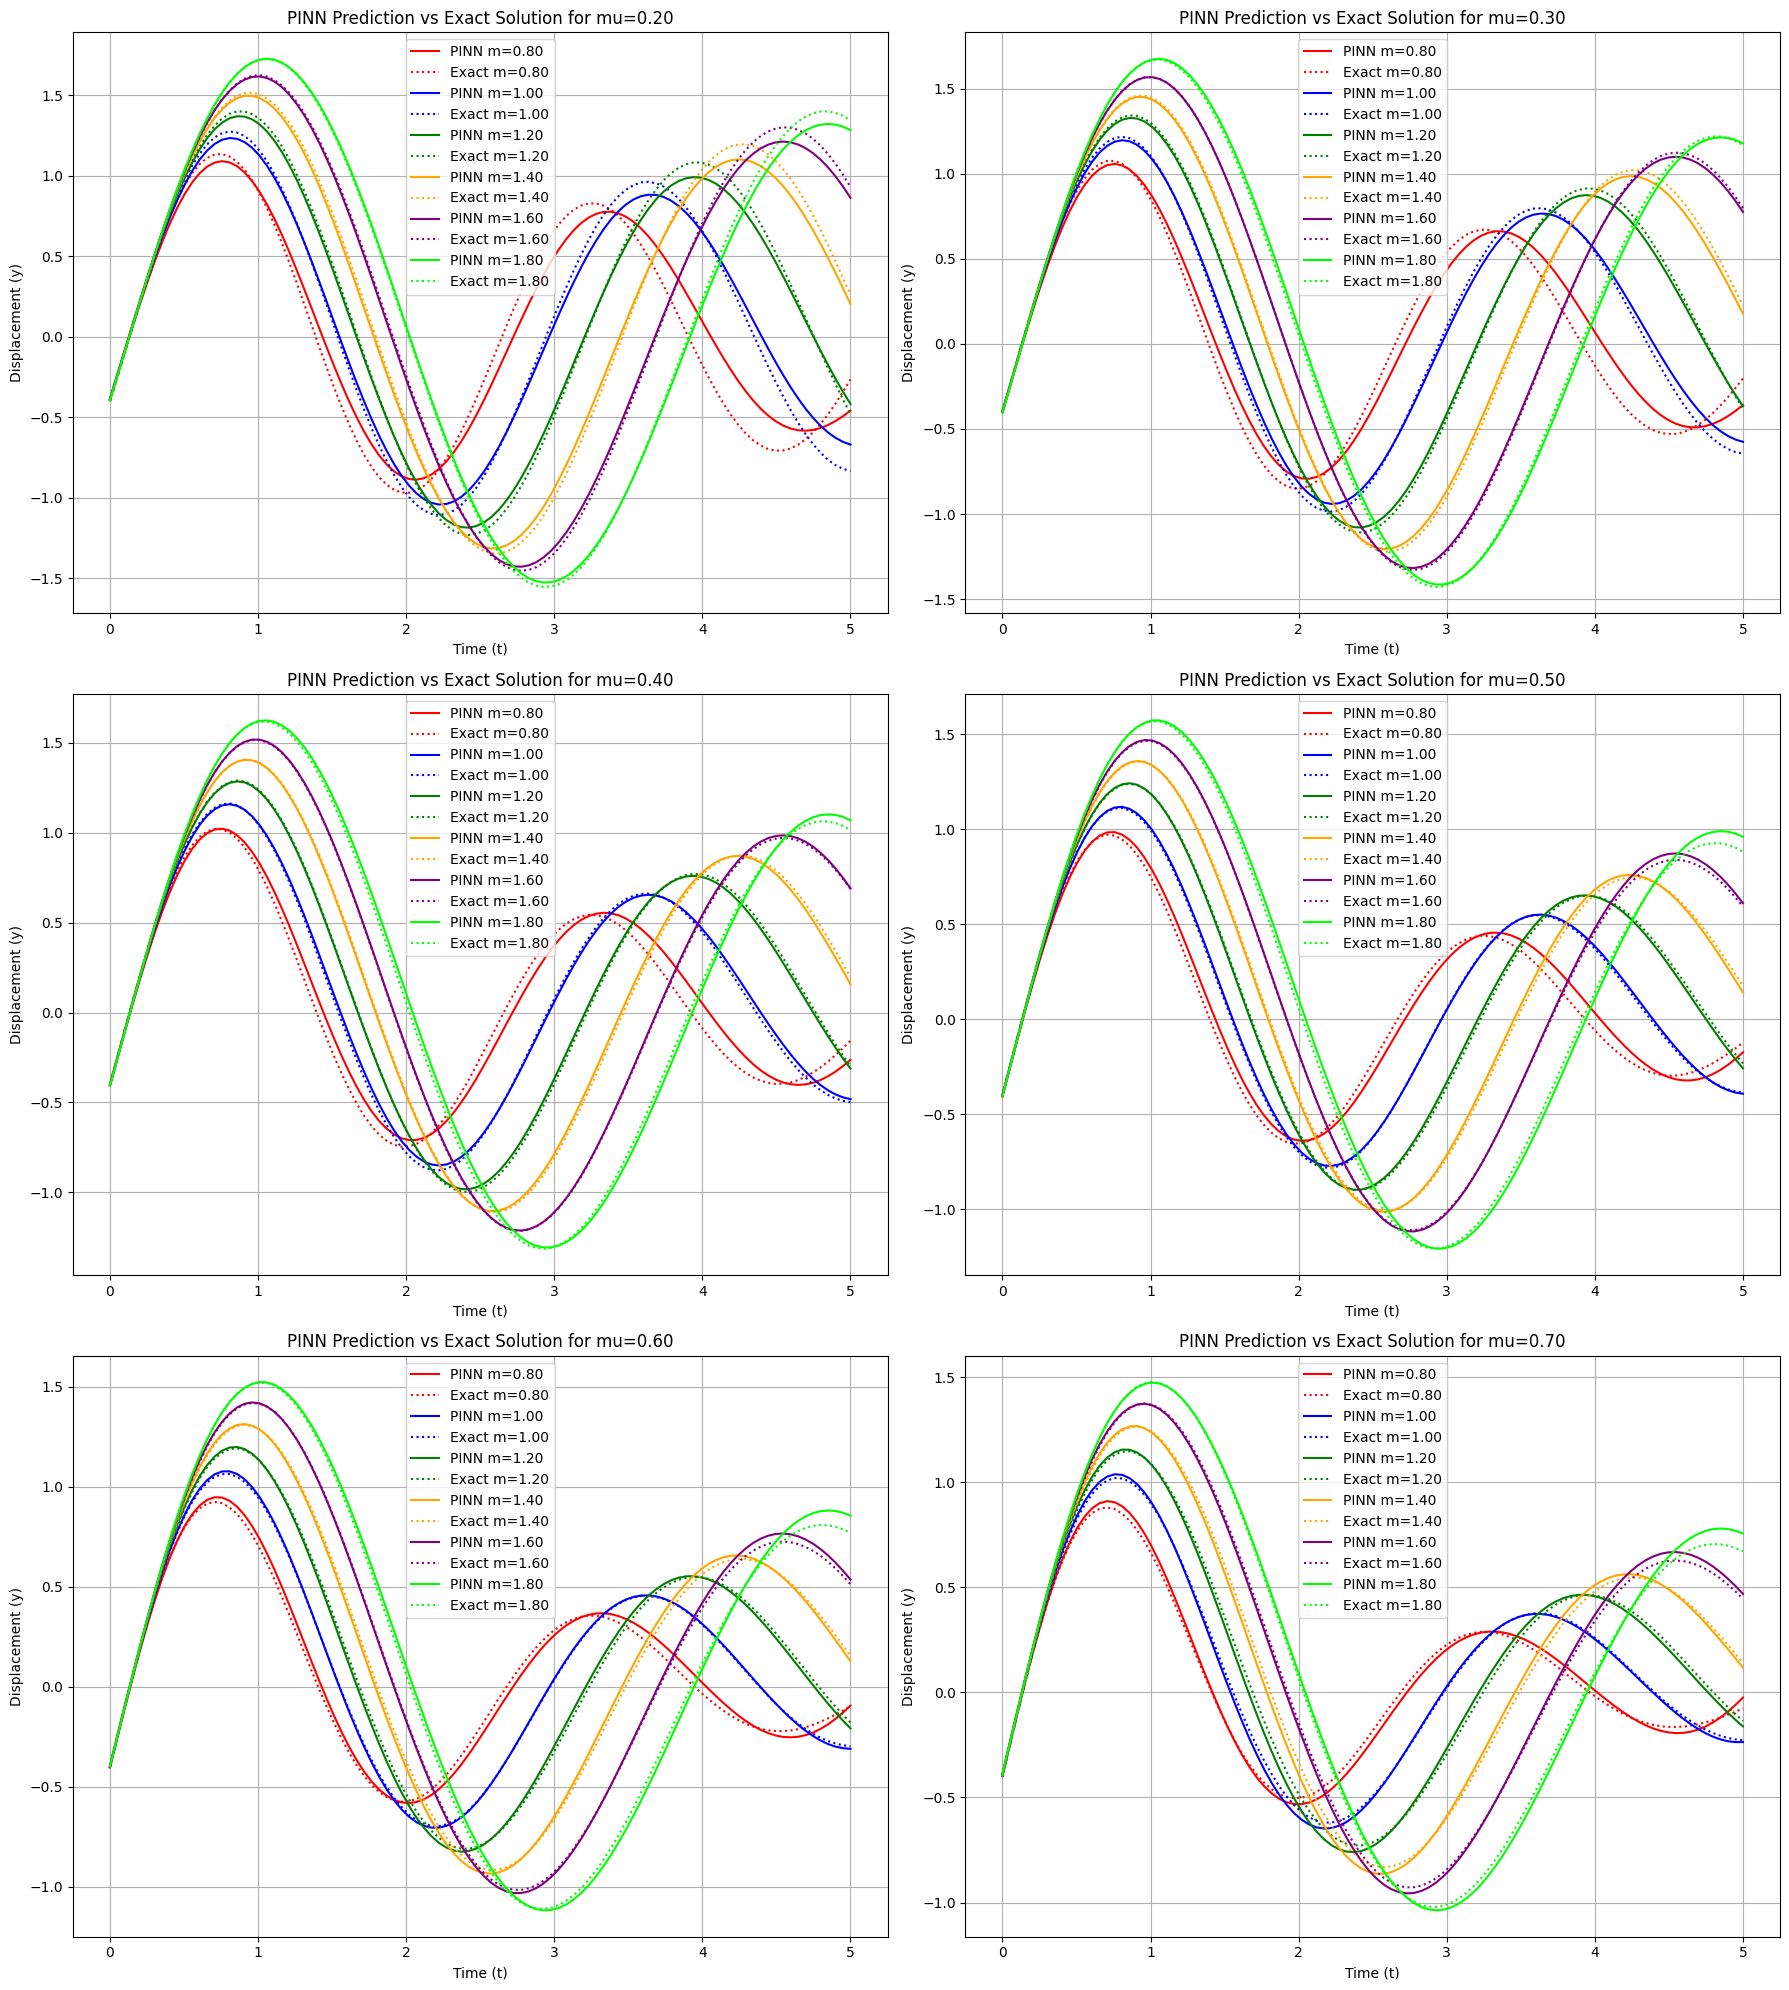

In [8]:
m_mean, m_std = 1.0, 0.1
mu_mean, mu_std = 0.6, 0.05
m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 6)
t_test = torch.linspace(0, 5, 100).view(-1, 1)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'lime']
mu_values = np.linspace(mu_mean - 8 * mu_std, mu_mean + 2 * mu_std, 6)

fig, axes = plt.subplots(3, 2, figsize=(18, 20))
axes = axes.flatten()

for ax, mu in zip(axes, mu_values):
    mu_test = torch.tensor([mu] * len(t_test), dtype=torch.float32).view(-1, 1)
    
    for idx, m in enumerate(m_values):
        color = colors[idx]
        m_test = torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1)
        y_pred = mass_mu_model(t_test, m_test, mu_test, k_val, y0_val, v0_val)
        y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), m=m, mu=mu, k=k_val.item(), y0=y0_val.item(), v0=v0_val.item())
        
        ax.plot(t_test.detach().numpy(), y_pred.detach().numpy(), color=color, label=f'PINN m={m:.2f}')
        ax.plot(t_test.detach().numpy(), y_exact, linestyle='dotted', color=color, label=f'Exact m={m:.2f}')
    
    ax.set_title(f'PINN Prediction vs Exact Solution for mu={mu:.2f}')
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Displacement (y)')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


In [9]:
m_mean, m_std = 1.0, 0.1
mu_mean, mu_std = 0.6, 0.05
k_fixed = 5.0
y0_fixed = -0.4
v0_fixed = 3.0

m_values = np.linspace(m_mean - 2 * m_std, m_mean + 8 * m_std, 6)
mu_values = np.linspace(mu_mean - 8 * mu_std, mu_mean + 2 * mu_std, 6)

t_test = torch.linspace(0, 5, 100).view(-1, 1)
errors = []
combos = list(itertools.product(m_values, mu_values))

for combo in combos:
    m_val_combo, mu_val_combo = combo
    # Create a test tensor for each parameter with length equal to t_test
    m_test = torch.tensor([m_val_combo] * len(t_test), dtype=torch.float32).view(-1, 1)
    mu_test = torch.tensor([mu_val_combo] * len(t_test), dtype=torch.float32).view(-1, 1)
    k_test = torch.tensor([k_fixed] * len(t_test), dtype=torch.float32).view(-1, 1)
    y0_test = torch.tensor([y0_fixed] * len(t_test), dtype=torch.float32).view(-1, 1)
    v0_test = torch.tensor([v0_fixed] * len(t_test), dtype=torch.float32).view(-1, 1)
    
    # Get the PINN prediction
    y_pred = mass_mu_model(t_test, m_test, mu_test, k_test, y0_test, v0_test)
    # Compute the exact solution using the provided function (convert t_test to numpy)
    y_exact = damped_harmonic_oscillator(t_test.detach().numpy(), 
                                         m=m_val_combo, mu=mu_val_combo, 
                                         k=k_fixed, y0=y0_fixed, 
                                         v0=v0_fixed)
    # Compute the mean squared error for this combination
    mse = np.mean((y_pred.detach().numpy() - y_exact)**2)
    errors.append(mse)
    # print(f"Combination (m, mu)=({m_val_combo:.2f}, {mu_val_combo:.2f}) -> MSE = {mse:.6f}")

combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all combinations: {combined_mse:.6f}")


Combined Mean Squared Error over all combinations: 0.001759


Combined Mean Squared Error over all combinations: 0.001759

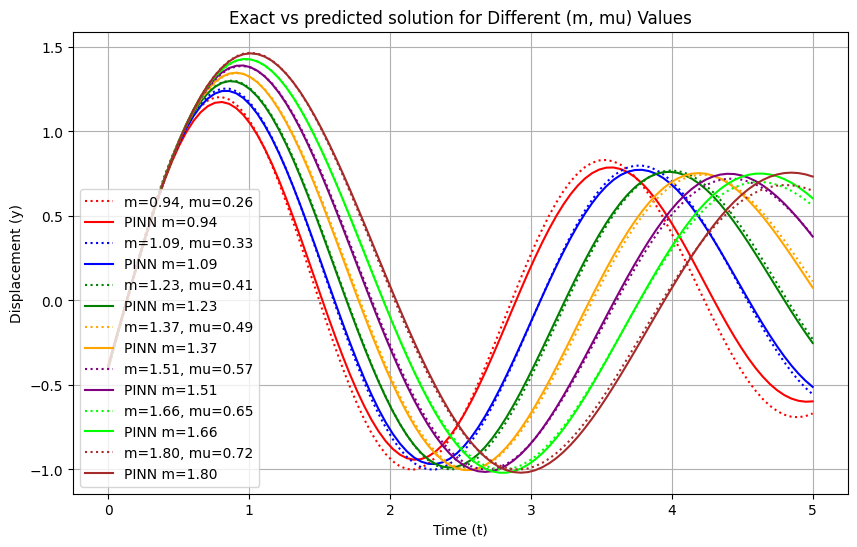


Combined Mean Squared Error over all combinations: 0.000980


In [10]:
from scipy.optimize import root_scalar

k_fixed = 5.0
y0_fixed = -0.4
v0_fixed = 3.0

# Define the range for m
m_values = np.linspace(mass_mean - 2 * mass_std, mass_mean + 8 * mass_std, 8)
colors = ['red', 'blue', 'green', 'orange', 'purple', 'lime', 'brown', 'pink', 'gray', 'cyan']
# Function to find mu for a given m where the exact solution is -1.0
def find_mu_for_exact_solution(m, t_test, k, y0, v0):
    def objective(mu):
        y_exact = damped_harmonic_oscillator(t_test, m=m, mu=mu, k=k, y0=y0, v0=v0)
        return np.min(y_exact) + 1.0  # We want the minimum to be exactly -1.0

    # Use a root-finding method to solve for mu
    # Check if the signs of the objective function at the bracket endpoints are different
    if objective(0.2) * objective(1.0) > 0:
        return None  # Skip root-finding if signs are not different

    result = root_scalar(objective, bracket=[0.2, 1.0], method='brentq')  # Adjust bracket as needed
    if result.converged:
        return result.root
    else:
        return None

# Time points for the exact solution
t_test = np.linspace(0, 5, 100)

# Find mu values for each m
mu_values = []
for m in m_values:
    mu = find_mu_for_exact_solution(m, t_test, k_fixed, y0_fixed, v0_fixed)
    if mu is not None:
        if mu < 0.2:  # Cap mu at 0.2 and adjust m accordingly
            def adjust_m_for_mu(mu_target):
                def m_objective(m):
                    y_exact = damped_harmonic_oscillator(t_test, m=m, mu=mu_target, k=k_fixed, y0=y0_fixed, v0=v0_fixed)
                    return np.min(y_exact) + 1.0  # We want the minimum to be exactly -1.0

                # Use a root-finding method to solve for m
                m_result = root_scalar(m_objective, bracket=[mass_mean - 2 * mass_std, mass_mean + 8 * mass_std], method='brentq')
                if m_result.converged:
                    return m_result.root
                else:
                    return None

            adjusted_m = adjust_m_for_mu(0.2)
            if adjusted_m is not None:
                mu_values.append((adjusted_m, 0.2))
        else:
            mu_values.append((m, mu))
# Plot the exact solution for the different (m, mu) values found
plt.figure(figsize=(10, 6))
idx=0
errors = []
for m, mu in mu_values:
    
    color = colors[idx]
    y_exact = damped_harmonic_oscillator(t_test, m=m, mu=mu, k=k_fixed, y0=y0_fixed, v0=v0_fixed)
    y_pred = mass_mu_model(torch.tensor(t_test, dtype=torch.float32).view(-1, 1),
                           torch.tensor([m] * len(t_test), dtype=torch.float32).view(-1, 1),
                           torch.tensor([mu] * len(t_test), dtype=torch.float32).view(-1, 1),
                           torch.tensor([k_fixed] * len(t_test), dtype=torch.float32).view(-1, 1),
                           torch.tensor([y0_fixed] * len(t_test), dtype=torch.float32).view(-1, 1),
                           torch.tensor([v0_fixed] * len(t_test), dtype=torch.float32).view(-1, 1))
    plt.plot(t_test, y_exact, label=f'm={m:.2f}, mu={mu:.2f}',linestyle='dotted',color=color)
    plt.plot(t_test, y_pred.detach().numpy(), color=color, label=f'PINN m={m:.2f}')

    mse=np.mean((y_pred.detach().numpy().flatten() - y_exact)**2)

    errors.append(mse)
    idx+=1
plt.xlabel('Time (t)')
plt.ylabel('Displacement (y)')
plt.title('Exact vs predicted solution for Different (m, mu) Values')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

combined_mse = np.mean(errors)
print(f"\nCombined Mean Squared Error over all combinations: {combined_mse:.6f}")

Below is an example of how you can build on your existing training code to search for candidate (mass, μ) pairs where the predicted minimum output is close to –1 (i.e. where

  g(m, μ) = min(model_prediction) + 1 ≈ 0),

while also keeping the search focused near the mean of your input distributions. In this example the candidate objective is defined as

  Objective(x) = |g(x)| + λ · [((mass – mass_mean)/mass_std)² + ((μ – μ_mean)/μ_std)²].

This formulation biases the search toward the “most probable point” (MPP) while still using a multi‐start, derivative‐free optimizer (Nelder–Mead) so that if there are additional failure regions, you can capture them by running several initial guesses.

## How This Works

### Candidate Evaluation (candidate_g)
For a given candidate \( x = [\text{mass}, \mu] \), the function creates tensors (with the same time-collocation points) and evaluates the PINN model. It then computes the minimum predicted output and adds 1 so that failure (when the oscillator reaches –1) corresponds to \( g(x) = 0 \).

### Candidate Objective
The objective is the absolute value of \( g(x) \) plus a penalty that grows as the candidate moves away from the mean values. This encourages the optimizer to prefer candidate points near the most probable region.

### Multi-Start Optimization
The code uses several random starting points (drawn from the input distributions) with SciPy’s `minimize` (using Nelder–Mead) to search for candidate points that satisfy the criterion. You then cluster these points to remove duplicates.

### Visualization
A contour plot of the candidate objective over a grid in (mass, μ) space is shown with the candidate points overlaid. This helps verify that the optimizer is finding regions on the failure boundary.

## Additional Thoughts
Since your PINN is differentiable (using `loss.backward()`), you could in principle compute gradients with respect to the input parameters and use a gradient-based method (or even form a Lagrangian \( L(x, \lambda) = \|x - \mu\|^2 + \lambda g(x) \)) to refine the search. This code uses a derivative-free approach for simplicity, but you might later experiment with methods that incorporate the PINN’s gradients directly.

The penalty term here does bias the optimization toward the MPP (most probable point). If you want to capture other failure regions on the \( g(x) = 0 \) manifold, you could run additional searches with a reduced penalty (or remove it altogether) and then compare the candidate clusters.

This integrated code should give you a good starting point for adaptively finding parameter values to focus your further training. Let me know if you need more details or further refinements!



Unique candidate points for further training:
mass = 1.2811, mu = 0.4371


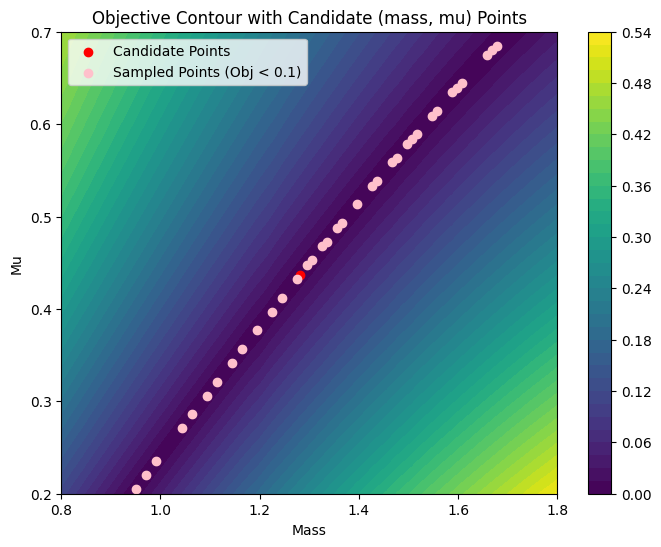

In [11]:
from scipy.optimize import minimize
# --- Candidate Search for (mass, mu) where g(x)=min(y_pred)+1 ≈ 0 ---
# We assume that during candidate search we fix the other parameters to the trained (or nominal) values:
mass_mean = 1.0
mass_std = 0.1
mu_mean = 0.6
mu_std = 0.05
lambda_penalty = 0.00  # Adjust the weight as needed

# Extract fixed parameter values (as scalars)
k = k_val.item()
y0 = y0_val.item()
v0 = v0_val.item()

def candidate_g(x, t_coll, k, y0, v0):
    """
    Given x = [mass, mu], evaluate g(x) = min(model_prediction) + 1 over the collocation points.
    """
    mass_val, mu_val_candidate = x
    # Create tensors for mass and mu that match the shape of t_coll
    m_tensor = torch.full_like(t_coll, mass_val)
    mu_tensor = torch.full_like(t_coll, mu_val_candidate)
    k_tensor = torch.full_like(t_coll, k)
    y0_tensor = torch.full_like(t_coll, y0)
    v0_tensor = torch.full_like(t_coll, v0)
    # Evaluate the model (set to eval mode and no grad)
    mass_mu_model.eval()
    with torch.no_grad():
        y_pred = mass_mu_model(t_coll, m_tensor, mu_tensor, k_tensor, y0_tensor, v0_tensor)
    y_min = y_pred.min()
    return y_min.item() + 1.0  # g(x) = predicted_minimum + 1.0

def candidate_objective(x, t_coll, k, y0, v0, mass_mean, mass_std, mu_mean, mu_std, lambda_penalty):
    """
    Objective function: minimize |g(x)| while penalizing deviation from the input means.
    """
    g_val = candidate_g(x, t_coll, k, y0, v0)
    penalty = lambda_penalty * ( ((x[0] - mass_mean)/mass_std)**2 + ((x[1] - mu_mean)/mu_std)**2 )
    return abs(g_val) + penalty

def find_candidate_points(n_initial, t_coll, k, y0, v0, mass_mean, mass_std, mu_mean, mu_std, lambda_penalty):
    candidate_points = []
    for i in range(n_initial):
        # Start with a random guess drawn from the input distributions.
        # init_mass = np.random.uniform(mass_mean, mass_std+5 * mass_std)
        # init_mu = np.random.uniform(mu_mean - 5 * mu_std, mu_mean )

        init_mass= mass_mean
        init_mu = mu_mean      

        init_guess = [init_mass, init_mu]
        res = minimize(
            candidate_objective, 
            init_guess, 
            args=(t_coll, k, y0, v0, mass_mean, mass_std, mu_mean, mu_std, lambda_penalty),
            method='Nelder-Mead'
        )
        if res.success:
            candidate_points.append(res.x)
        else:
            print(f"Start {i}: Optimization did not converge from initial guess {init_guess}")
    return candidate_points

# Run the multi-start candidate search:
n_initial = 10  # number of initial guesses
candidates = find_candidate_points(n_initial, t_coll, k, y0, v0,
                                   mass_mean, mass_std, mu_mean, mu_std, lambda_penalty)

# Optionally, remove duplicates (if candidate points are very close)
unique_candidates = []
tol = 1.0e-1
for pt in candidates:
    if not any(np.linalg.norm(pt - np.array(up)) < tol for up in unique_candidates):
        unique_candidates.append(pt)

print("\nUnique candidate points for further training:")
for pt in unique_candidates:
    print(f"mass = {pt[0]:.4f}, mu = {pt[1]:.4f}")

# --- Optional: Visualization of the Candidate Objective ---
mass_vals = np.linspace(mass_mean - 2 * mass_std, mass_mean + 8 * mass_std, 100)
mu_vals = np.linspace(mu_mean - 8 * mu_std, mu_mean + 2 * mu_std, 100)
Mass, Mu = np.meshgrid(mass_vals, mu_vals)
Obj = np.zeros_like(Mass)

for i in range(Mass.shape[0]):
    for j in range(Mass.shape[1]):
        Obj[i, j] = candidate_objective([Mass[i, j], Mu[i, j]], t_coll, k, y0, v0,
                                        mass_mean, mass_std, mu_mean, mu_std, lambda_penalty)

plt.figure(figsize=(8, 6))
cp = plt.contourf(Mass, Mu, Obj, levels=50, cmap='viridis')
plt.colorbar(cp)
plt.scatter([pt[0] for pt in unique_candidates], [pt[1] for pt in unique_candidates],
            color='red', label='Candidate Points')

# Sample 100 random points where Obj < 0.1
valid_indices = np.where(Obj < 0.001)
valid_mass = Mass[valid_indices]
valid_mu = Mu[valid_indices]
if len(valid_mass) >= 100:
    sampled_indices = np.random.choice(len(valid_mass), 100, replace=False)
    sampled_mass = valid_mass[sampled_indices]
    sampled_mu = valid_mu[sampled_indices]
else:
    sampled_mass = valid_mass
    sampled_mu = valid_mu

plt.scatter(sampled_mass, sampled_mu, color='pink', label='Sampled Points (Obj < 0.1)')
plt.xlabel('Mass')
plt.ylabel('Mu')
plt.title('Objective Contour with Candidate (mass, mu) Points')
plt.legend()
plt.show()


Plan: 

Find the areas where it is within some limit and inside some range of each paramter instead of the MPP. Maybe also find the MPP. Then use that to train further. If it is far away, training further should not change anything.

In [12]:
mass = 1.2109
mu = 0.3789
t_test = torch.linspace(0, 5, 100).view(-1, 1)
m_test = torch.tensor([mass] * len(t_test), dtype=torch.float32).view(-1, 1)
mu_test = torch.tensor([mu] * len(t_test), dtype=torch.float32).view(-1, 1)
y_pred= mass_mu_model(t_test, m_test, mu_test, k_val, y0_val, v0_val).min()
print(y_pred)

y_actual = damped_harmonic_oscillator(t_test, m=mass, mu=mu, k=k, y0=y0, v0=v0).min()
print(y_actual)

tensor(-1.0093, grad_fn=<MinBackward1>)
tensor(-1.0268)


One common approach is to “walk” along the limit‐state surface by taking small steps in directions tangent to the surface at the MPP and then “projecting” back onto the surface. In other words, once you’ve found the MPP (i.e. the point x* such that g(x*) ≃ 0), you can:

#### Compute the local gradient at the MPP:
Determine ∇g(x*) either by using automatic differentiation (if your model permits) or by finite differences. This gradient is normal to the surface g(x) = 0.

#### Determine the tangent space:
For an n‑dimensional problem (n = 2 in your current case), the tangent space at x* is the (n – 1)-dimensional hyperplane perpendicular to ∇g(x*). In 2D you simply have one tangent direction (and its opposite). In higher dimensions, you can use techniques like singular value decomposition (SVD) to find an orthonormal basis for the null space of ∇g(x*).

#### Sample directions in the tangent space:
For each sample, choose a unit vector from the tangent space. In 2D this means taking the vector orthogonal to ∇g(x*), then using both its positive and negative directions if needed. In higher dimensions you can sample uniformly over the unit sphere in the tangent space.

#### Step off the MPP and project back onto g(x)=0:
For each tangent direction and a given step size (or several step sizes to cover “some distance”), generate a candidate point

\[ x_{\text{cand}} = x^* + d \, v_{\text{tan}} \]

Then use a projection method (for example, a Newton iteration) to adjust \( x_{\text{cand}} \) so that it satisfies \( g(x) = 0 \) within a tolerance. A simple Newton correction is:

\[ x_{\text{new}} = x_{\text{cand}} - \frac{g(x_{\text{cand}})}{\|\nabla g(x_{\text{cand}})\|^2} \nabla g(x_{\text{cand}}) \]

Iterate this update until \( |g(x)| \) is below your chosen tolerance.

#### Collect these points:
This way you get a collection of “probable” points along the surface \( g(x) = 0 \) in all directions from the MPP. In higher dimensions, you can repeat this procedure for various directions in the (n–1)-dimensional tangent space.

Below is some example pseudocode (in Python) illustrating this idea in a generic way:


In [13]:
# Finite-difference gradient of g at point x.
def grad_g(x, t_coll, k, y0, v0, h=1e-6):
    grad = np.zeros_like(x)
    for i in range(len(x)):
        x_up = x.copy()
        x_down = x.copy()
        x_up[i] += h
        x_down[i] -= h
        grad[i] = (candidate_g(x_up, t_coll, k, y0, v0) - candidate_g(x_down, t_coll, k, y0, v0)) / (2*h)
    return grad

# Compute tangent basis at x using SVD. Returns an array of shape (n-1, n)
def tangent_basis(grad):
    # Reshape grad to 1 x n matrix.
    U, s, Vt = np.linalg.svd(grad.reshape(1, -1))
    # The remaining rows of Vt form an orthonormal basis for the tangent space.
    return Vt[1:]  # shape: (n-1, n)

# Project a point x onto g(x)=0 using a simple Newton iteration.
def project_onto_g(x, t_coll, k, y0, v0, tol=1e-6, max_iter=50):
    for i in range(max_iter):
        gx = candidate_g(x, t_coll, k, y0, v0)
        if abs(gx) < tol:
            break
        grad_val = grad_g(x, t_coll, k, y0, v0)
        norm_grad2 = np.dot(grad_val, grad_val)
        if norm_grad2 < tol:  # Avoid division by nearly zero
            break
        x = x - (gx / norm_grad2) * grad_val
    return x

# Sample along the surface g(x)=0 from the MPP (x_mpp)
def sample_along_g(x_mpp, t_coll, k, y0, v0, distances, n_samples=10):
    grad_at_mpp = grad_g(x_mpp, t_coll, k, y0, v0)
    # Get tangent basis (in 2D this is a 1x2 array; in nD, shape: (n-1, n))
    T = tangent_basis(grad_at_mpp)
    samples = []
    # For each distance and each sample direction in the tangent space
    for d in distances:
        # For 2D, T has one row; use both positive and negative directions.
        if T.shape[0] == 1:
            for sign in [1, -1]:
                direction = sign * T[0]  # unit vector
                x_cand = x_mpp + d * direction
                # Project back onto g(x)=0
                x_proj = project_onto_g(x_cand, t_coll, k, y0, v0)
                samples.append(x_proj)
        else:
            # In higher dimensions, sample random directions uniformly in the tangent space.
            for _ in range(n_samples):
                # Sample a random vector in R^(n-1)
                v = np.random.randn(T.shape[0])
                v /= np.linalg.norm(v)
                # Map to R^n: linear combination of the basis vectors.
                direction = np.dot(v, T)
                x_cand = x_mpp + d * direction
                x_proj = project_onto_g(x_cand, t_coll, k, y0, v0)
                samples.append(x_proj)
    return samples

# Example usage:
# Assume x_mpp is the MPP you found (e.g., from unique_candidates[0])
# and distances is a list of step sizes (e.g., np.linspace(0.1, 1.0, 10))
x_mpp = unique_candidates[0]  # your MPP (assumes only ONE MPP!!)
distances = np.linspace(0.0, 0.3, 25)  # adjust based on your problem scale
sampled_points = sample_along_g(x_mpp, t_coll, k, y0, v0, distances)

print("Sampled points along g(x)=0:")
for pt in sampled_points:
    print(f"mass = {pt[0]:.4f}, mu = {pt[1]:.4f}")


Sampled points along g(x)=0:
mass = 1.2811, mu = 0.4371
mass = 1.2811, mu = 0.4371
mass = 1.2917, mu = 0.4443
mass = 1.2704, mu = 0.4298
mass = 1.3015, mu = 0.4507
mass = 1.2606, mu = 0.4232
mass = 1.3106, mu = 0.4568
mass = 1.2498, mu = 0.4156
mass = 1.3235, mu = 0.4656
mass = 1.2391, mu = 0.4085
mass = 1.3308, mu = 0.4704
mass = 1.2326, mu = 0.4040
mass = 1.3396, mu = 0.4760
mass = 1.2243, mu = 0.3980
mass = 1.3549, mu = 0.4865
mass = 1.2107, mu = 0.3877
mass = 1.3618, mu = 0.4911
mass = 1.2020, mu = 0.3817
mass = 1.3724, mu = 0.4980
mass = 1.1916, mu = 0.3753
mass = 1.3817, mu = 0.5041
mass = 1.1807, mu = 0.3682
mass = 1.3888, mu = 0.5087
mass = 1.1682, mu = 0.3596
mass = 1.4047, mu = 0.5191
mass = 1.1579, mu = 0.3523
mass = 1.4093, mu = 0.5221
mass = 1.1521, mu = 0.3483
mass = 1.4291, mu = 0.5345
mass = 1.1461, mu = 0.3441
mass = 1.4340, mu = 0.5378
mass = 1.1325, mu = 0.3346
mass = 1.4431, mu = 0.5438
mass = 1.1291, mu = 0.3321
mass = 1.4585, mu = 0.5534
mass = 1.1132, mu = 0.3210

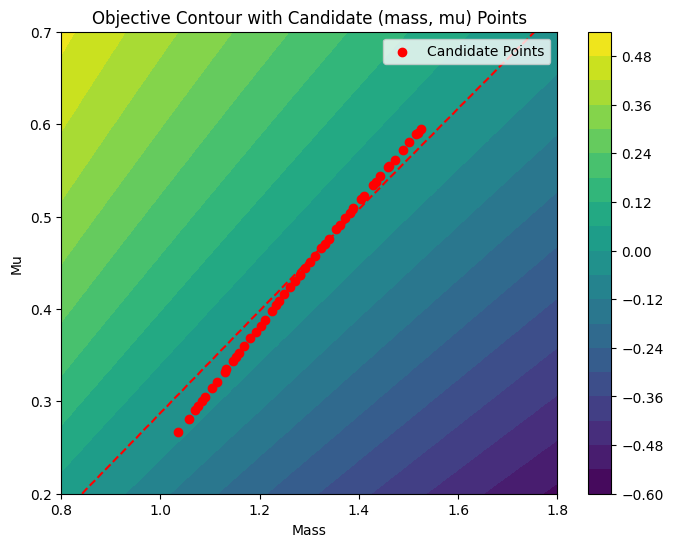

In [14]:
t_show = torch.tensor(np.linspace(0, 3, 100), dtype=torch.float32)
# --- Optional: Visualization of the Candidate Objective ---
mass_vals = np.linspace(mass_mean - 2 * mass_std, mass_mean + 8 * mass_std, 100)
mu_vals = np.linspace(mu_mean - 8 * mu_std, mu_mean + 2 * mu_std, 100) 
Mass, Mu = np.meshgrid(mass_vals, mu_vals)
Obj = np.zeros_like(Mass)
for i in range(Mass.shape[0]):
    for j in range(Mass.shape[1]):
        y_exact = damped_harmonic_oscillator(t_show.detach().numpy(), m=Mass[i, j], mu=Mu[i, j], k=k, y0=y0, v0=v0)
        Obj[i, j] = np.min(y_exact) + 1.0  # Compute the minimum value and add 1.0
        

plt.figure(figsize=(8, 6))
cp = plt.contourf(Mass, Mu, Obj, levels=20, cmap='viridis')
plt.colorbar(cp)
plt.contour(Mass, Mu, Obj, levels=[0], colors='red', linestyles='--')  # Add a contour line at obj = 0
plt.scatter([pt[0] for pt in sampled_points], [pt[1] for pt in sampled_points],
            color='red', label='Candidate Points')
plt.xlabel('Mass')
plt.ylabel('Mu')
plt.title('Objective Contour with Candidate (mass, mu) Points')
plt.legend()
plt.show()

In [15]:
first_elements = [point[0] for point in sampled_points]
second_elements = [point[1] for point in sampled_points]
print((first_elements))

print(sampled_mass)

[1.2811005729203317, 1.2811005729203317, 1.291726135768691, 1.2703571682690415, 1.3014911013427606, 1.2606424961537335, 1.3106142734165398, 1.249826514372538, 1.3235279628537848, 1.2391310601177858, 1.3308460740200927, 1.2325903505109566, 1.3395856767747851, 1.2242892403715295, 1.3548785732363195, 1.2106513958496652, 1.36183204266605, 1.2019652103917136, 1.3724194722277696, 1.1916196927153582, 1.381699100789189, 1.1807310867043441, 1.3888191973285486, 1.1681786223095354, 1.4046550360607466, 1.1579374379413458, 1.409332556906289, 1.1521001469139638, 1.4291011370602307, 1.1460572935249886, 1.4339942746914616, 1.1325006182991937, 1.4431256390679534, 1.129145014309941, 1.458498582026847, 1.1131601152422976, 1.4610611095284218, 1.1031767867307547, 1.4724116828208387, 1.089290597004517, 1.487962800470397, 1.0840006432446807, 1.5010439173913095, 1.0759846565456999, 1.5156320137217256, 1.069670738935886, 1.518830351790242, 1.0565671230351756, 1.5252659231227645, 1.035950001213448]
[0.95151515 

Epoch 0, PDE loss: 0.00822591781616211, BC loss: 9.824886365095153e-05


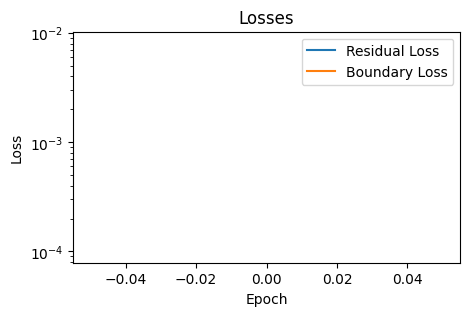

Epoch 1000, PDE loss: 0.00042553734965622425, BC loss: 5.390207297750749e-05


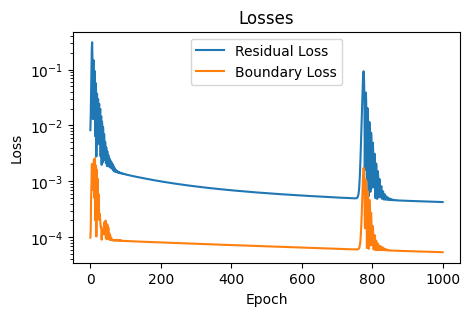

Epoch 2000, PDE loss: 0.00030941699515096843, BC loss: 3.9328468119492754e-05


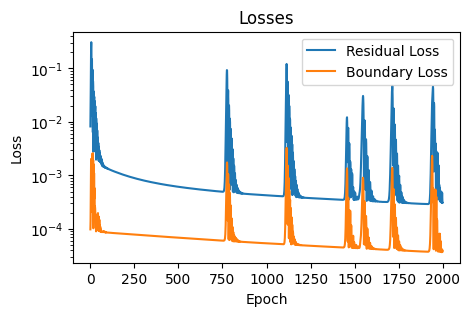

Epoch 3000, PDE loss: 0.02620825171470642, BC loss: 0.0007707743206992745


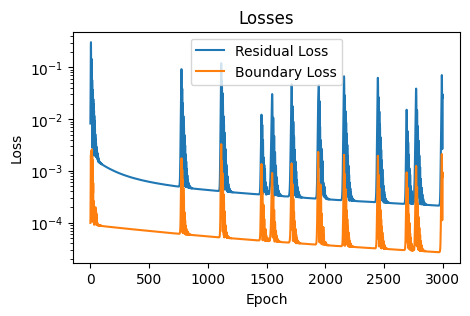

Epoch 4000, PDE loss: 0.00021101065794937313, BC loss: 2.1667694454663433e-05


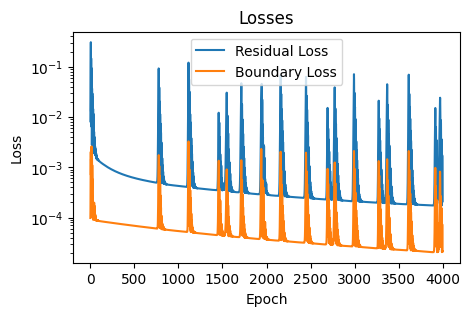

In [16]:
# Run training pipeline
t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0 = initialize_uniform_mass_mu(len(sampled_mu))
# Convert sampled_points to tensors
sampled_mass = torch.tensor(sampled_mass, dtype=torch.float32).view(-1, 1)
sampled_mu = torch.tensor(sampled_mu, dtype=torch.float32).view(-1, 1)
trainer = Trainer(mass_mu_model, optimizer,epochs=4001)
trainer.train(t_coll, sampled_mass, sampled_mu, k_val, y0_val, v0_val, t0)

### With gradient from pytorch!:

In [17]:

def candidate_g_torch(x_tensor, t_coll, k, y0, v0):
    # x_tensor is a torch tensor with shape (2,) and requires_grad=True
    mass_val, mu_val_candidate = x_tensor[0], x_tensor[1]
    # Create tensors for mass and mu that match the shape of t_coll
    m_tensor = torch.full_like(t_coll, mass_val)
    mu_tensor = torch.full_like(t_coll, mu_val_candidate)
    k_tensor = torch.full_like(t_coll, k)
    y0_tensor = torch.full_like(t_coll, y0)
    v0_tensor = torch.full_like(t_coll, v0)
    
    # Evaluate the model in eval mode
    mass_mu_model.eval()
    # Do not use torch.no_grad() because we need gradients!
    y_pred = mass_mu_model(t_coll, m_tensor, mu_tensor, k_tensor, y0_tensor, v0_tensor)
    y_min = y_pred.min()
    return y_min + 1.0  # g(x) = predicted_minimum + 1.0

def grad_g_pytorch(x, t_coll, k, y0, v0):
    # Convert x to a torch tensor with gradients enabled.
    x_tensor = torch.tensor(x, dtype=torch.float32, requires_grad=True)
    # Compute the function value.
    g_val = candidate_g_torch(x_tensor, t_coll, k, y0, v0)
    # Backward pass to compute gradients.
    g_val.backward()
    # Extract and return the gradient as a numpy array.
    return x_tensor.grad.detach().numpy()

# Example usage:
x_example = [mass_mean, mu_mean]  # or any starting point
gradient = grad_g_pytorch(x_example, t_coll, k, y0, v0)
print("Gradient at x:", gradient)


TypeError: full_like(): argument 'fill_value' (position 2) must be Number, not Tensor

Below is an example that demonstrates how to compute the gradient of your limit‐state function g(x) with respect to the input parameters (here, mass and μ) and how to set up a simple Lagrangian in PyTorch. In this example, we define

  g(x) = min(model_prediction(x)) + 1.0

where the model is your trained PINN. We then form a Lagrangian

  L(x, λ) = ‖x – μ_mean‖² + λ · g(x)

and show how you can compute the gradients with respect to both x and the multiplier λ.

Note: Because the min() operation may be non‐smooth, you might consider using a smooth approximation (e.g. a softmin) if you encounter difficulties. For illustration, we use torch.min below.

## Explanation
### Computing g(x):
The function compute_g(x, t_coll, k, y0, v0) constructs tensors for the mass and damping parameters (from x) that match the collocation points t_coll. It then runs the trained model to compute the predicted oscillator outputs and returns the value of
  g(x) = min(model_prediction) + 1.0.

The gradient of g(x) with respect to x is obtained using torch.autograd.grad.

### Setting Up the Lagrangian:
We form the Lagrangian
  L(x, λ) = ‖x – μ_mean‖² + λ · g(x)

where the first term penalizes deviation from the mean, and the second enforces the constraint g(x)=0.

We initialize x (our candidate parameters) and λ as learnable tensors (with requires_grad=True), and then set up an optimizer (here Adam) to update both.

### Optimization Loop:
In each iteration, we compute g(x) and the squared distance term, form the Lagrangian, call backward() to compute gradients, and then step the optimizer. Over iterations, if a feasible solution exists, x should be driven to a region where g(x) is close to zero, while also trying to stay near the mean.

### Using Gradients:
The code snippet shows how to compute the gradient of g(x) explicitly (with torch.autograd.grad), which is useful if you want to analyze the sensitivity of g or include higher-order derivatives in your optimization.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Suppose mass_model is your trained PINN (an instance of PINN_m)
# And t_coll is your collocation points tensor (with shape [N, 1])
# Fixed parameters (scalars)
k = 5.0
y0 = -0.4
v0 = 3.0

# Parameter distribution means and stds (for mass and mu)
mass_mean = 1.0
mass_std = 0.1
mu_mean = 0.6
mu_std = 0.1

# Example collocation points (if not already defined)
N = 500
t_coll = torch.rand(N, 1) * 5.0
t_coll.requires_grad = True

# Define a function to compute g(x)
def compute_g(x, t_coll, k, y0, v0):
    """
    x: a tensor of shape (2,) representing [mass, mu], with requires_grad=True.
    Returns:
       g(x) = min(model_prediction) + 1.0 over the collocation points.
    """
    mass_val, mu_val = x[0], x[1]
    # Create tensors matching t_coll's shape
    m_tensor = mass_val * torch.ones_like(t_coll)
    mu_tensor = mu_val * torch.ones_like(t_coll)
    k_tensor = k * torch.ones_like(t_coll)
    y0_tensor = y0 * torch.ones_like(t_coll)
    v0_tensor = v0 * torch.ones_like(t_coll)
    
    # Set model to evaluation mode
    mass_mu_model.eval()
    # Compute model predictions (ensure no grad for intermediate forward pass)
    y_pred = mass_mu_model(t_coll, m_tensor, mu_tensor, k_tensor, y0_tensor, v0_tensor)
    
    # Compute g as min(y_pred) + 1.0.
    # (For a differentiable approximation, consider a smooth-min if needed.)
    g_val = torch.min(y_pred) + 1.0
    return g_val

# Example: Compute gradient of g(x) with respect to x
# Start with an initial guess for x = [mass, mu]
x = torch.tensor([mass_mean, mu_mean], dtype=torch.float32, requires_grad=True)

g_val = compute_g(x, t_coll, k, y0, v0)
# Compute gradient using torch.autograd.grad; create_graph=True allows higher derivatives.
grad_g = torch.autograd.grad(g_val, x, create_graph=True)[0]
print("g(x) =", g_val.item())
print("Gradient of g(x) w.r.t x:", grad_g)

# --- Setting Up the Lagrangian ---

# We now set up the Lagrangian L(x, λ) = ‖x - μ_mean_vector‖² + λ * g(x)
# where μ_mean_vector = [mass_mean, mu_mean]

# Initialize x and the Lagrange multiplier lambda (as a learnable parameter)
x = torch.tensor([mass_mean, mu_mean], dtype=torch.float32, requires_grad=True)
lam = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)

# Define an optimizer that will update both x and lam
optimizer = optim.Adam([x, lam], lr=1e-3)

# Run a few iterations to see how the gradients update the variables
n_iter = 2000
for i in range(n_iter):
    optimizer.zero_grad()
    
    # Compute g(x)
    g_val = compute_g(x, t_coll, k, y0, v0)
    # Compute the distance squared from the mean (for both mass and mu)
    mean_vec = torch.tensor([mass_mean, mu_mean], dtype=torch.float32)
    dist_sq = torch.sum((x - mean_vec)**2)
    # Form the Lagrangian: we want g(x)=0 and x close to the mean
    Lagrangian = dist_sq + lam * g_val
    
    Lagrangian.backward()
    optimizer.step()
    
    # (Optional) Print progress every 200 iterations
    if i % 200 == 0:
        print(f"Iteration {i}: Lagrangian = {Lagrangian.item():.6f}, g(x) = {g_val.item():.6f}, x = {x.detach().numpy()}, lambda = {lam.item():.6f}")

# After optimization, x should be near a point where g(x) ≈ 0 (if feasible)
print("Optimized x (mass, mu):", x.detach().numpy())
print("Optimized Lagrange multiplier lambda:", lam.item())


### Adaptive Update for λ:
 After each update of x, we update λ by adding a term proportional to g(x). This way, if g(x) is still significantly nonzero (i.e. the constraint is not satisfied), λ will increase, forcing future iterations to prioritize driving g(x) closer to zero.

### Tuning:
 The initial value of λ and the step size α for updating it are hyperparameters. You might need to experiment with these to ensure that your optimization finds the true MPP—that is, the point on the failure boundary (g(x)=0) that is as close as possible to the mean.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Assume mass_model, t_coll, k, y0, v0 are defined as before.

# Parameter distribution means and stds for mass and mu:
mass_mean = 1.0
mu_mean = 0.6

# Define the function to compute g(x)
def compute_g(x, t_coll, k, y0, v0):
    # x is a tensor: [mass, mu]
    mass_val, mu_val = x[0], x[1]
    m_tensor = mass_val * torch.ones_like(t_coll)
    mu_tensor = mu_val * torch.ones_like(t_coll)
    k_tensor = k * torch.ones_like(t_coll)
    y0_tensor = y0 * torch.ones_like(t_coll)
    v0_tensor = v0 * torch.ones_like(t_coll)
    mass_mu_model.eval()
    with torch.no_grad():
        y_pred = mass_mu_model(t_coll, m_tensor, mu_tensor, k_tensor, y0_tensor, v0_tensor)
    # Using torch.min gives a non-smooth operation; for a smoother gradient, consider a soft-min.
    return torch.min(y_pred) + 1.0

# Initialize x (the candidate [mass, mu]) and the Lagrange multiplier lambda.
x = torch.tensor([mass_mean, mu_mean], dtype=torch.float32, requires_grad=True)
lam = torch.tensor(10.0, dtype=torch.float32, requires_grad=True)  # Start with a moderate lambda

# Use a simple optimizer for x; we can update lambda separately.
optimizer = optim.Adam([x], lr=1e-3)
# Set a step size for updating lambda (this could be tuned)
alpha = 1e-2
n_iter = 2000

for i in range(n_iter):
    optimizer.zero_grad()
    
    # Compute the constraint function
    g_val = compute_g(x, t_coll, k, y0, v0)
    # Compute the squared distance from the mean: here we assume the mean vector is [mass_mean, mu_mean]
    mean_vec = torch.tensor([mass_mean, mu_mean], dtype=torch.float32)
    dist_sq = torch.sum((x - mean_vec)**2)
    
    # Form the Lagrangian: L(x, lambda) = distance term + lambda * g(x)
    Lagrangian = dist_sq + lam * g_val
    
    Lagrangian.backward()
    optimizer.step()
    
    # Augmented Lagrangian update for lambda: increase lambda if constraint violation is high.
    # Here we update lambda based on g(x) (we want g(x) -> 0).
    with torch.no_grad():
        lam += alpha * g_val  # Increase lambda proportionally to the constraint violation
    
    if i % 200 == 0:
        print(f"Iter {i}: Lagrangian={Lagrangian.item():.6f}, g(x)={g_val.item():.6f}, x={x.detach().numpy()}, lambda={lam.item():.4f}")

print("Optimized (mass, mu):", x.detach().numpy())
print("Final lambda:", lam.item())
